In [5]:
import pandas as pd
import numpy as np
import h5py
#import illustris_python as il
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib widget
from tqdm import tqdm_notebook
#import skysurvey_pw as skysurvey
import skysurvey
import requests
import glob
import os

import h5py
from astropy.cosmology import Planck15 as cosmo

from photutils.aperture import CircularAperture,aperture_photometry
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.io import fits

import warnings
from tqdm.notebook import tqdm


from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "xtick.top":True,
    "xtick.direction":'in',
    "ytick.right":True,
    "ytick.direction":'in',
    "xtick.labelsize":14,
    "ytick.labelsize":14,
    "axes.labelsize":22,
    
})


def convert_phot(aperture_sum,zp):
    return -2.5*np.log10(aperture_sum) + zp
def convert_phot_fnu(aperture_sum,zp):
    return 10**(np.log10(aperture_sum)-0.4*(zp-8.9))
    
def do_ap_phot(img_path,snx=0,sny=0,pix_list=None,pos_list=None,zp=0,ax=None,band=0,plot_colour='w',plot=False):
    #zp does not matter if we are just doing colours.
    img = fits.getdata(img_path)[band]
    h = fits.getheader(img_path)
    #wgt = 1/np.var(img)
    #print(img.shape,wgt.shape)
    #wcs = WCS(h)
    # First do the inner apperture with DLR <1
    if not pix_list:
        pix_list=[snx,sny]
         
    if not pos_list:
        pos_list=[snx,sny]
    pixscale_physical = 1000/h['CDELT1']/cosmo.h
    ap = CircularAperture(pix_list,r=pixscale_physical)
    phot_df = aperture_photometry(img, ap,error=0.1*img).to_pandas()
    
    res =convert_phot(phot_df['aperture_sum'],zp)
    #res_fnu =convert_phot_fnu(phot_df['aperture_sum'],zp)
    res_err = convert_phot(phot_df['aperture_sum_err'],zp)
    if plot:
        plot_ap =  CircularAperture(pos_list,r=1)
        ##ap.positions = 
        plot_ap.plot(ax=ax,alpha=0.15,color=plot_colour)
    return ap,res, res_err

    
def plot_step(data,cut_par, cut_val,plot_2bin=True,bins=None,f=None,ax=None,
              colour=None,bincolour=None,binlabel=None,labelext='',scatter=True,scatterlabel='DES5YR',
             binmarker='D',fillmeans=True):
    data = data[~pd.isna(data[[cut_par,'MURES','MUERR']])]
    if not f:
        f,ax=plt.subplots(figsize=(8,6.5))
    if not colour:
        colour='#5c068c'
    if scatter:
        if scatterlabel:
            label=scatterlabel
        else:
            label=None
        ax.scatter(data[cut_par],data['MURES'],marker='.',alpha=0.5,label=label,color=colour)
    if plot_2bin:
        left = data[data[cut_par]<cut_val]
        right = data[data[cut_par]>=cut_val]
        left_mean = np.average(left['MURES'],weights = 1/left['MUERR']**2)
        left_std = np.std(left['MURES'])/np.sqrt(len(left))
        right_mean = np.average(right['MURES'],weights = 1/right['MUERR']**2)
        right_std = np.std(right['MURES'])/np.sqrt(len(right))
        xleftmean = np.average(left[cut_par])
        xrightmean= np.average(right[cut_par])
        print('xleftmean: ',xleftmean, 'xlefterr: ',xleftmean,cut_val-xleftmean)
        print('xrightmean: ',xrightmean, 'xrighterr: ',xrightmean-cut_val,np.max(right[cut_par])-xrightmean)
        ax.errorbar([xleftmean,xrightmean],[left_mean,right_mean],
                    yerr=[left_std,right_std],xerr=[[xleftmean,xrightmean-cut_val],
                    [cut_val-xleftmean,np.max(right[cut_par])-xrightmean]],
                    marker='s',
                    markersize=15,color=colour,linestyle='none',mew=2,mec='k')
        if fillmeans:
            xlows = np.linspace(np.min(data[cut_par]),cut_val,100)
            ax.fill_between(xlows,left_mean-left_std,left_mean+left_std,color=colour,alpha=0.2)
            xhighs = np.linspace(cut_val,np.max(data[cut_par]),100)
            ax.fill_between(xhighs,right_mean-right_std,right_mean+right_std,color=colour,alpha=0.2)
    if bins!=None:
        if type(bins) in [list,np.ndarray]:
            pass
        elif type(bins) in [float,int,np.float32,np.float64,np.int32,np.int64]:
            bw = (data[cut_par].max()-data[cut_par].min())/bins
            binmax= data[cut_par].max()+bw
            bins = np.arange(data[cut_par].min(),binmax,bw)
        labelcounter=0
        for n,g in data.groupby(pd.cut(data[cut_par],bins=bins)):
            if len(g)>0:
                
                
                mean = np.average(g['MURES'],weights=1/g['MUERR']**2)
                #err = np.mean(g['MUERR'])/np.sqrt(len(g))
                err = np.std(g['MURES'])/np.sqrt(len(g))
                x=np.mean(g[cut_par])
                if bincolour:
                    colour=bincolour
                if binlabel:
                    if labelcounter==0:
                        label=binlabel
                        labelcounter+=1
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,label=label,alpha=0.95
                           )
                    else:
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,alpha=0.95
                           )
                else:
                    ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,alpha=0.95
                           )
                    
                
    return f,ax

def plot_scatter(data,x_par,y_par,x_err,y_err,bins=None,f=None,ax=None,
              colour=None,bincolour=None,binlabel=None,labelext='',scatter=True,scatterlabel='DES5YR',
             binmarker='D',how=np.mean):
    data = data[~pd.isna(data[[x_par,y_par,y_err]])]
    if not f:
        f,ax=plt.subplots(figsize=(8,6.5))
    if not colour:
        colour='#5c068c'
    if scatter:
        if scatterlabel:
            label=scatterlabel
        else:
            label=None
        ax.scatter(data[x_par],data[y_par],marker='.',alpha=0.5,label=label,color=colour)
    if bins!=None:
        if type(bins) in [list,np.ndarray]:
            pass
        elif type(bins) in [float,int,np.float32,np.float64,np.int32,np.int64]:
            bw = (data[x_par].max()-data[x_par].min())/bins
            binmax= data[x_par].max()+bw
            bins = np.arange(data[x_par].min(),binmax,bw)
        labelcounter=0
        for n,g in data.groupby(pd.cut(data[x_par],bins=bins)):
            if len(g)>0:
                #print('plotting in bins')                
                mean = np.average(g[y_par],weights=1/g[y_err]**2)
                #err = np.mean(g['MUERR'])/np.sqrt(len(g))
                err = np.std(g[y_par])/np.sqrt(len(g))
                x=np.mean(g[x_par])
                if bincolour:
                    colour=bincolour
                if binlabel:
                    if labelcounter==0:
                        label=binlabel
                        labelcounter+=1
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,label=label,alpha=0.95
                           )
                        #print('plotted errorbar',x,mean,err)
                    else:
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,alpha=0.95
                           )
                        #print('plotted errorbar',x,mean,err)
                else:
                    ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,alpha=0.95
                           )
                
    return f,ax




def get_step(data,cut_par,cut_val,verbose=True):
    #cut_par_err = cut_par+cut_par_err_ext
    data = data[~pd.isna(data[[cut_par,'MURES','MUERR']])]
    left = data[data[cut_par]<cut_val]
    right = data[data[cut_par]>=cut_val]
    left_mean = np.average(left['MURES'],weights = 1/left['MUERR']**2)
    left_stderr = np.std(left['MURES'])/np.sqrt(len(left))
    left_weighted_stderr = np.sqrt(1/np.sum(1/left['MUERR']**2))
    right_mean = np.average(right['MURES'],weights = 1/right['MUERR']**2)
    right_stderr = np.std(right['MURES'])/np.sqrt(len(right))
    right_weighted_stderr = np.sqrt(1/np.sum(1/right['MUERR']**2))
    if verbose:
        print('Splitting at %s = %.3f'%(cut_par,cut_val))
        #print('Mean mures Low %s: %.3f+/-%.3f'%(cut_par,left_mean,left_stderr), 'Mean mures High %s: %.3f+/-%.3f'%(cut_par,right_mean,right_stderr))
        #print('Weighted stderrs. Left: %.3f, right %.3f'%(left_weighted_stderr,right_weighted_stderr))
        print('Step: %.3f+/-%.3f mag'%(left_mean - right_mean, np.sqrt(left_stderr**2 + right_stderr**2)))
        print('Significance: %.2f sigma'%((left_mean - right_mean)/np.sqrt(left_stderr**2 + right_stderr**2)))
    return left_mean - right_mean, np.sqrt(left_stderr**2 + right_stderr**2)


# get d_DLR

def get_DLR_ABT(x_pos, y_pos,  A_IMAGE, B_IMAGE, orientation_ellip, angsep):
    '''Function for calculating the DLR of a galaxy - SN pair (taken from dessne)'''
    #print('Inputs: ',x_pos, y_pos,  A_IMAGE, B_IMAGE, orientation_ellip, angsep)
   
    # angle between RA-axis and SN-host vector
    GAMMA = np.arctan(-y_pos/x_pos)
    #print('GAMMA',GAMMA)
    # angle between semi-major axis of host and SN-host vector
    PHI = orientation_ellip + GAMMA # angle between semi-major axis of host and SN-host vector
    #print('PHI',PHI)
    rPHI = A_IMAGE*B_IMAGE/np.sqrt((A_IMAGE*np.sin(PHI))**2 +
                                     (B_IMAGE*np.cos(PHI))**2)
    #print('rPHI',rPHI)
    # directional light radius
    #  where 2nd moments are bad, set d_DLR = 99.99
    d_DLR = angsep/rPHI

    return d_DLR
def angles(x_pos,y_pos,orientation_ellip):# angle between RA-axis and SN-host vector
    GAMMA = np.arctan(-y_pos/x_pos)
    #print('GAMMA',GAMMA)
    # angle between semi-major axis of host and SN-host vector
    PHI = orientation_ellip + GAMMA # angle between semi-major axis of host and SN-host vector
    print(GAMMA,PHI)
    print(np.rad2deg(GAMMA),np.rad2deg(PHI))

def dtd_pl(age, A=2.11e-13, beta=-1.13, t0=40):
        """Default delay time distribution function."""
        p = ((age*1000 < t0)*0) + ((age*1000>t0)*A * (age**beta))
        #if age*1000 < t0:
        #    return 0
        return p

def get_hostid(hostfunc=dtd_pl,ages=None):
    rates = hostfunc(ages,)
    print(rates)
    ids = np.random.choice(np.arange(len(ages)),p=rates/np.sum(rates))
    print(ids)
    return ids

# abstract it all into a single func

def get_host(ages,A=2.11e-13, beta=-1.13, t0=40):
    p = ((ages*1000 < t0)*0) + ((ages*1000>t0)*A * (ages**beta))
    return np.random.choice(np.arange(len(ages)),p=p/np.sum(p))


def get_metallicity(hostId,galcat):
    return galcat['metallicity'].iloc[hostId]
def get_progage(hostId,galcat):
    return galcat['age'].iloc[hostId]
from scipy.special import expit
from scipy.stats import norm
def x1_g24_age_metallicity(**kwargs):
    age =kwargs['age']
    metallicity = kwargs['metallicity']
    mu1,sig1,mu2,sig2,Km,rred,rblue,Kc,agesplit = [i for i in kwargs['params']]
    r = rred+((rblue-rred)*expit((age-agesplit)/Kc))
    
    #r=np.array(r)
    #print(r)
    Zsol=0
    x1low = (Km*(metallicity-Zsol))+mu2
    x1high = (Km*(metallicity-Zsol))+mu1
    norm1 = norm(x1high,sig1)
    norm2 = norm(x1low,sig2)
    choice = (np.random.rand(len(age))>r).astype(int)
    #choice = np.random.choice([0,1],p=[r,1-r])
    #print(choice)
    #print(choice.shape)
    n1rvs = norm1.rvs()
    n2rvs = norm2.rvs()
    #print('norm 1',n1rvs.shape,np.mean(n1rvs))
    #print('norm 2',n2rvs.shape,np.mean(n2rvs))
    x1=((choice==0)*n1rvs )+((choice==1)*n2rvs )
    #print(x1.shape)
    return x1

def age_step(**kwargs):
    age =kwargs['age']
    agesplit = kwargs['agesplit']
    Ka = kwargs['Ka']
    r = expit((age-agesplit)/Ka)
    choice = (np.random.rand(len(age))>r).astype(int)
    #print(age[:10],choice[:10])
    step = ((choice==0)*0.1)+((choice==1)*-0.1)
    #print(step[:10])
    magabs = -19.3+step
    #print(magabs[:10])
    return magabs

def distmod(mobs,x1,c,mabs=-19.3,alpha=-0.14,beta=3.15):
    return mobs-mabs -(alpha*x1 + beta*c)
def hubres(distmod,z,cosmo=None):
    if cosmo==None:
        from astropy.cosmology import Planck18 as cosmo
    return distmod - cosmo.distmod(z).value
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"eba6365a63ff327c63d284349c914245"}
def get(path, params=None,savepath=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
         if savepath==None:
             savepath=''
         
         filename = savepath+r.headers['content-disposition'].split("filename=")[1]
         #print('writing to file',filename)
         with open(filename, 'wb') as f:
             f.write(r.content)
         return filename # return the filename string
    return r
bases = {'TNG50-1':baseUrl+'TNG50-1/snapshots/96/',
        'TNG100-1':baseUrl+'TNG100-1/snapshots/96/'}

In [6]:
# using TNG50-1
sim = 'TNG50-1'
data_dir = f'data/{sim}/'


In [ ]:
star_formers = {}
star_bursts = {}
passives = {}
from tqdm import tqdm_notebook as tqdm
globstr = os.path.join(data_dir,'snap96','*')
print(globstr)
dirs = glob.glob(globstr)
#print(dirs)

for dirname in tqdm(dirs):
    subhaloId = dirname.split('/')[-1]
    rstring = bases[sim]+f'subhalos/{subhaloId}'
    #print(rstring)
    thissub =get(bases[sim]+f'subhalos/{subhaloId}')
    #print(thissub)
    mass_stars = thissub['mass_stars']
    
    if mass_stars>0:
        sfr = thissub['sfr']
        ssfr = sfr/mass_stars
        if ssfr>10:
            star_bursts[subhaloId]=[mass_stars,sfr,ssfr]
        elif ssfr <0.1:
            passives[subhaloId]=[mass_stars,sfr,ssfr]
        else:
            star_formers[subhaloId]=[mass_stars,sfr,ssfr]

In [93]:
SFmeta = pd.DataFrame(star_formers)
SFmeta = SFmeta.T
SFmeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

SBmeta = pd.DataFrame(star_bursts)
SBmeta = SBmeta.T
SBmeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

passivemeta = pd.DataFrame(passives)
passivemeta = passivemeta.T
passivemeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

galmeta = pd.concat([SFmeta,SBmeta,passivemeta])
galmeta['mass_stars_true'] = galmeta['mass_stars']*1E10/ 0.6774


In [94]:
galmeta.to_csv(os.path.join(data_dir,'galmeta.csv'),index=False)

In [89]:
gal=galmeta[(galmeta['mass_stars_true']<1e9)&(galmeta['mass_stars_true']>1e8)].sample(n=1)

In [90]:
subhaloId = int(gal.index[0])
print(subhaloId,np.log10(gal['mass_stars_true']))

229117 229117    8.816097
Name: mass_stars_true, dtype: float64


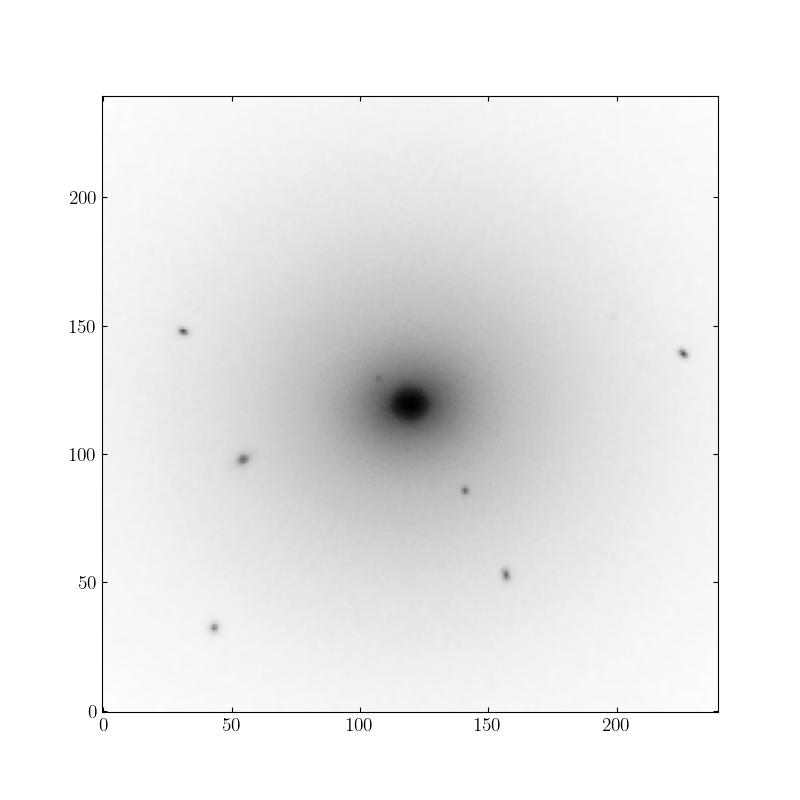

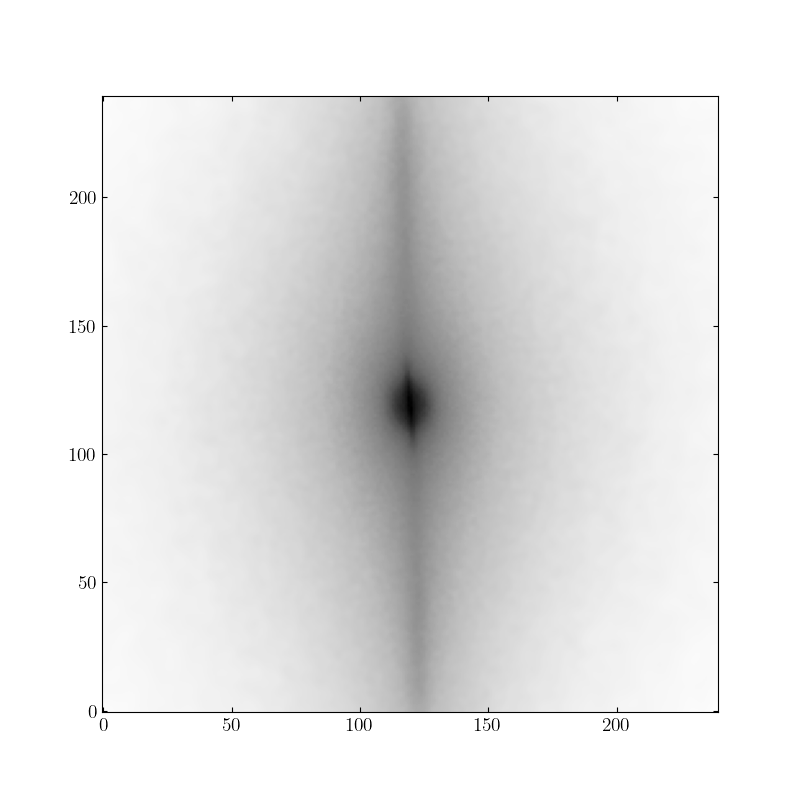

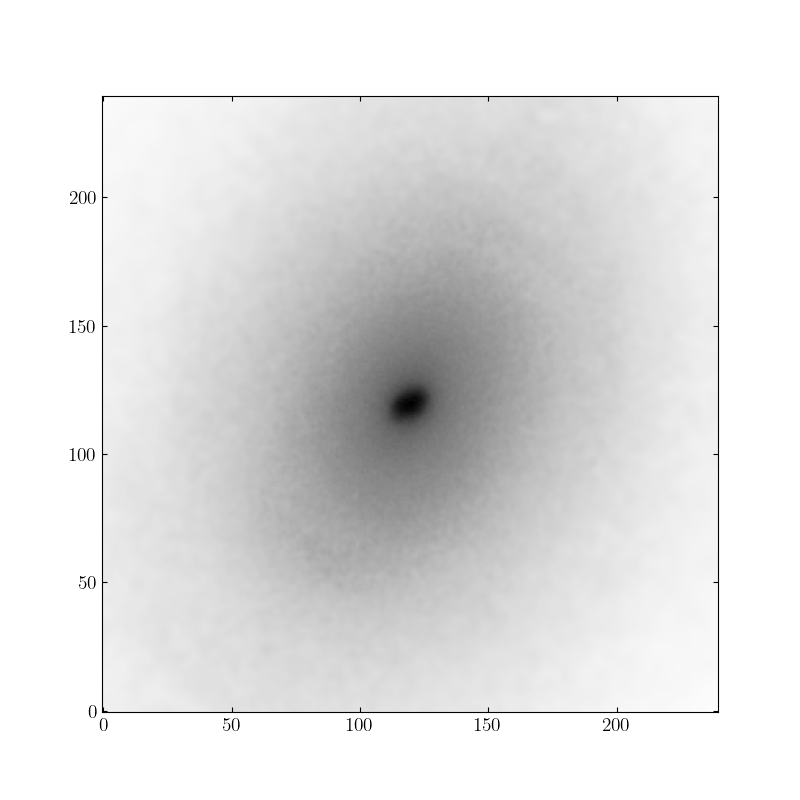

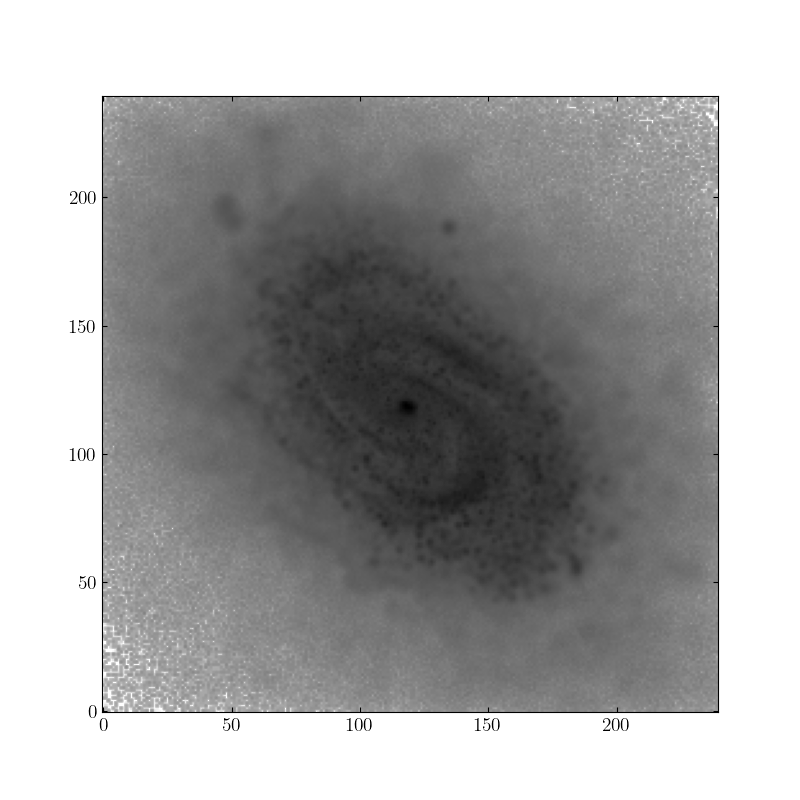

In [96]:
# Add noise to KiDS images

import pandas as pd
import numpy as np
import glob
import os
from astropy.visualization import simple_norm
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from scipy.stats import norm

sim = 'TNG50-1'
kidsdir = f'data/{sim}/KIDS/snapnum_096/zx/data/'
galmeta = pd.read_csv(os.path.join(data_dir, 'galmeta.csv'))

# Parameters for realism
psf_fwhm = 0.7  # FWHM of the PSF in arcseconds
gain = 3e13  # Effective gain in electrons per data unit
sigma_bkg = 2e-12  # Background noise standard deviation in ADU/s

for subhaloId in galmeta.index[:4]:
    subhaloId = int(subhaloId)
    hdul = fits.open(os.path.join(kidsdir, f'broadband_{subhaloId}.fits'))
    h = hdul[0].header
    image_data = hdul[0].data

    # Convolve with 2D Gaussian PSF
    pixelscale = h['PIXSCALE']  # Arcseconds per pixel
    sigma_psf = psf_fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0))) / pixelscale  # Convert FWHM to sigma in pixels
    convolved_image = gaussian_filter(image_data, sigma=sigma_psf)

    # Add shot noise
    shot_noise = np.random.poisson(convolved_image * gain) / gain

    # Add background noise
    background_noise = np.random.normal(0, sigma_bkg, convolved_image.shape)

    # Combine all components
    noisy_image = convolved_image + shot_noise + background_noise

    # Save the noisy image to a new FITS file
    #noisy_hdul = fits.HDUList([fits.PrimaryHDU(data=noisy_image, header=h)])
    #noisy_hdul.writeto(os.path.join(kidsdir, f'noisy_broadband_{subhaloId}.fits'), overwrite=True)
    f,ax=plt.subplots(figsize=(8,8))
    boxsizex = h['CDELT1']*h['NAXIS1']*cosmo.h/1000
    xmin=xmax = boxsizex/2
    
    boxsizey = h['CDELT2']*h['NAXIS2']*cosmo.h/1000
    ymin=ymax = boxsizex/2
    ax.imshow(hdul[0].data[0],cmap='Greys',norm='log',origin='lower'),#extent=[-xmin,xmax,-ymin,ymax])
    hdul.close()
    
#ax.scatter(drawn_gals['x_pos'],drawn_gals['y_pos'],marker='o',color='navy',s=5,alpha=0.5)
#ax.set_xlim(-25,25)
#ax.set_ylim(-25,25)

#xs = np.linspace(-20,20,100)
#ys = xs*np.tan(this_subhalo_morph['orientation_asymmetry'].values[0])
#ax.plot(xs,ys,ls='--',color='c')

In [92]:
hdul[0].data[0].flatten()

array([1.0897292e-15, 8.7513237e-16, 1.5483465e-15, ..., 2.0133080e-15,
       1.4378412e-15, 1.8845238e-15], dtype='>f4')